In [2]:
import pandas as pd

from actors import (Ship, Geopoint, speed_limitations, detect_point_category, IceCategory,
                    VesselCategory, Port, Geopoint, VesselMoveStatus, Icebreaker, Route)
from utils import find_and_serialize_neighbors, load_serialized_neighbors
from route_metrics import ice_metrics_on_route, get_closest_grid_points_on_route_step, route_steps_on_edge, ice_integral_coefficient_on_step

## Готовим данные

In [3]:
grid = pd.read_excel(r"data\velocity.xlsx")
routes = pd.read_excel(r"data\routes.xlsx")
ports = pd.read_excel(r"data\ports.xlsx")
vessels = pd.read_excel(r"data\vessels.xlsx")
iceboats = pd.read_excel(r"data\iceboat.xlsx")
schedule = pd.read_excel(r"data\schedule.xlsx")

In [4]:
find_and_serialize_neighbors(grid=grid[["lat", "lon"]].values, static_folder="data")

In [7]:
64.7844 - 64.5703

0.21410000000000196

In [5]:
grid

,lon,lat,03-Mar-2020,10-Mar-2020,17-Mar-2020,24-Mar-2020,31-Mar-2020,02-Apr-2020,07-Apr-2020,14-Apr-2020,21-Apr-2020,28-Apr-2020,05-May-2020,12-May-2020,19-May-2020,26-May-2020
0,20,64.3565,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
1,20,64.5703,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
2,20,64.7844,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
3,20,64.9986,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
4,20,65.2130,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58368,144,35.6178,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
58369,144,35.5171,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
58370,144,35.4160,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0
58371,144,35.3145,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0


## Примеры создания акторов

In [4]:
# Класс порта (узлы графа)
Port(name=ports["point_name"][0], geopoint=Geopoint(ports["lat"][0], ports["lon"][0]))

Port(name='Бухта Север и Диксон', geopoint=Geopoint(latitude=73.1, longitude=80.0))

In [5]:
# Класс ледокола
icebreaker = Icebreaker(name="Вайгач",
     category=VesselCategory.arc92,
     location_point=Port(
         name="Победа месторождение", geopoint=Geopoint(68.5, 73.7)
     ),
     route_request=None,
     status=VesselMoveStatus.waiting,
     max_speed=20,
     avg_speed=0.0,
     curr_speed=0.0)
icebreaker

Icebreaker(name='Вайгач', category=<VesselCategory.arc92: 10>, location_point=Port(name='Победа месторождение', geopoint=Geopoint(latitude=68.5, longitude=73.7)), route_request=None, status=<VesselMoveStatus.waiting: 0>, max_speed=20, avg_speed=0.0, curr_speed=0.0)

In [6]:
# Класс корабля
ship = Ship(name="ДЮК II",
     category=VesselCategory.arc5,
     location_point=Port(name="Новый порт", geopoint=Geopoint(68.5, 73.7)),
     route_request=None,
     status=VesselMoveStatus.waiting,
     max_speed=25,
     avg_speed=0.0,
     curr_speed=0.0)
ship

Ship(name='ДЮК II', category=<VesselCategory.arc5: 5>, location_point=Port(name='Новый порт', geopoint=Geopoint(latitude=68.5, longitude=73.7)), route_request=None, status=<VesselMoveStatus.waiting: 0>, max_speed=25, avg_speed=0.0, curr_speed=0.0)

In [7]:
# Ограничения на скорость в зависимости от судна и льда
speed_limitations[detect_point_category(17)](ship)

20.0

In [8]:
# Класс Route
route = Route(ports=[
    Port(name=ports["point_name"][0], geopoint=Geopoint(ports["lat"][0], ports["lon"][0])),
    Port(name=ports["point_name"][1], geopoint=Geopoint(ports["lat"][1], ports["lon"][1]))
])

route

Route(ports=[Port(name='Бухта Север и Диксон', geopoint=Geopoint(latitude=73.1, longitude=80.0)), Port(name='Дудинка', geopoint=Geopoint(latitude=69.4, longitude=86.15))], steps=[[(73.09, 80.0), (73.08, 80.01), (73.08, 80.02), (73.07, 80.03), (73.07, 80.04), (73.06, 80.05), (73.05, 80.06), (73.05, 80.07), (73.04, 80.08), (73.04, 80.09), (73.03, 80.1), (73.02, 80.11), (73.02, 80.12), (73.01, 80.13), (73.01, 80.14), (73.0, 80.15), (72.99, 80.16), (72.99, 80.17), (72.98, 80.18), (72.98, 80.19), (72.97, 80.2), (72.96, 80.21), (72.96, 80.22), (72.95, 80.23), (72.95, 80.24), (72.94, 80.25), (72.93, 80.26), (72.93, 80.27), (72.92, 80.28), (72.92, 80.29), (72.91, 80.3), (72.9, 80.31), (72.9, 80.32), (72.89, 80.33), (72.89, 80.34), (72.88, 80.35), (72.87, 80.36), (72.87, 80.37), (72.86, 80.38), (72.86, 80.39), (72.85, 80.4), (72.84, 80.41), (72.84, 80.42), (72.83, 80.43), (72.83, 80.44), (72.82, 80.45), (72.81, 80.46), (72.81, 80.47), (72.8, 80.48), (72.8, 80.49), (72.79, 80.5), (72.78, 80.51),

In [9]:
# Расчет состояния льда для ребра 0 в route
route.ice_state_on_edge(date=2, grid=grid.values, pair_idx=0)

C:\Users\Lenovo\code\hack_led\nothern_sea_router\route_metrics.py:43: RuntimeWarning: Mean of empty slice.
  res = np.where(ice_metric<=0, ice_metric[ice_metric>0].mean(), ice_metric)
D:\home\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 12.1003065, 12.1003065, 10.       ,
        10.       , 10.       , 10.       , 10.       , 10.       ,
        10.       , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.8

### Детали по Route

In [10]:
# Вычисление всех квадратов на ребре
all_points_on_edge = route_steps_on_edge(67.58,	47.82,	70.30,	57.80)
all_points_on_edge[:10]

[(67.58, 47.82),
 (67.58, 47.83),
 (67.59, 47.84),
 (67.59, 47.85),
 (67.59, 47.86),
 (67.59, 47.87),
 (67.6, 47.88),
 (67.6, 47.89),
 (67.6, 47.9),
 (67.6, 47.91)]

In [11]:
# Поиск ближайших соседей для расчета метрик
closest = get_closest_grid_points_on_route_step(load_serialized_neighbors("data"), all_points_on_edge)
closest[:10]

[[12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938]]

In [12]:
# Метрики на маршруте - все клетки и только уникальные
ice_metrics_on_route(
    closest_quadrants=closest,
    grid=grid.values,
    date_num_col=2
)

(array([20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.43017

In [1]:
ice_integral_coefficient_on_step()

NameError: name 'ice_integral_coefficient_on_step' is not defined

<Axes: >

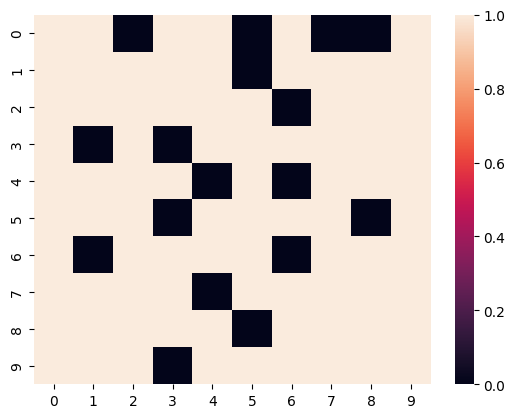

In [43]:
from seaborn import heatmap
from envs.waterworld import WaterWorld

map_shape = (10, 10)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (5, 5),
    'max_episode_steps': 25,
}
heatmap(water_map)

In [44]:
from ray.rllib.algorithms import PPOConfig

try:
    algo.stop()
except:
    pass

training_options = {
    'train_batch_size': 256,
    #'sgd_minibatch': 64,
    #'lr': 1e-05,
    #'num_sgd_iter': 22,
    'model': {
        #'fcnet_activation': 'relu',
        #'fcnet_hiddens': [256, 256],
        'vf_share_layers': False,
        #'use_lstm': True,
    }
}

cql_config = (
    PPOConfig()
    .environment(env=WaterWorld, env_config=config)
    .framework('torch')
    .rollouts(num_rollout_workers=0)
    .evaluation(evaluation_num_workers=0, evaluation_interval=1)
    .training(**training_options)
)
algo = cql_config.build()

d:\Code\Python\Lib\site-packages\ray\rllib\algorithms\algorithm.py:500: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
d:\Code\Python\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
d:\Code\Python\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by se

In [55]:
for i in range(100):
    hist = algo.step()
    print(f'iter {i}\t {hist["sampler_results"]["episode_reward_mean"]}')

iter 0	 -4.390952600420578
iter 1	 -4.586657823660955
iter 2	 -5.353411509626825
iter 3	 -4.464127015505707
iter 4	 -3.8329069340779056
iter 5	 -5.25676823124192
iter 6	 -3.001004599251432
iter 7	 -4.179164493560409
iter 8	 -2.629123214438875
iter 9	 -4.344464619674398
iter 10	 -6.756076342829374
iter 11	 -6.250974802236462
iter 12	 -5.6982434053516045
iter 13	 -5.64103574279105
iter 14	 -6.6150526686348
iter 15	 -5.203167360952973
iter 16	 -2.3387426818409183
iter 17	 -2.234211656508218
iter 18	 -3.5046160658824403
iter 19	 -3.414902238392243
iter 20	 -3.676903248206749
iter 21	 -3.0387246024609826
iter 22	 -1.968082641247122
iter 23	 -3.373162022245537
iter 24	 -2.612273416067986
iter 25	 -4.445010853852296
iter 26	 -6.644201404484504
iter 27	 -7.231807462907307
iter 28	 -6.960287651510952
iter 29	 -2.6740898653911933
iter 30	 -2.361915207291367
iter 31	 -0.8178250436299025
iter 32	 -1.656992409812738
iter 33	 -2.1872760715718145
iter 34	 -3.2603709604464917
iter 35	 -2.9665874628751

(8, 6) (8, 0)


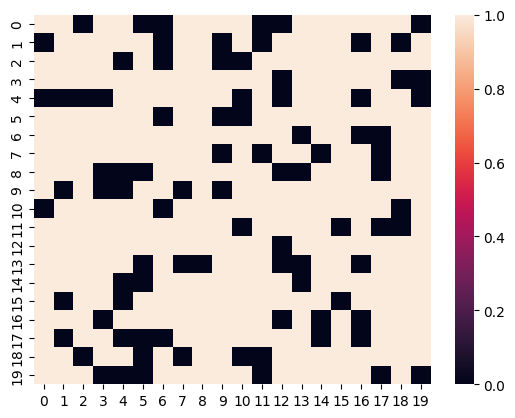

In [57]:
map_shape = (20, 20)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (5, 5),
    'max_episode_steps': 30,
}
heatmap(water_map)

ww = WaterWorld(config=config)
ww.reset()
print(ww.ship.geo, ww.way_point)

In [59]:
def alg_eval(env: WaterWorld, algo):
    all_actions = []
    total_profit = 0
    cords = []
    obs, _ = env.reset()
    while True:
        x = algo.compute_single_action(obs, explore=False)
        obs, profit, term, trunc, _ = env.step(x)

        all_actions.append(x)
        total_profit += profit
        cords.append(env.ship.int_geo)
        if term or trunc:
            break

    return {
        'total_profit': total_profit,
        'actions': all_actions,
        'cords': cords,
    }

8.960418025323342


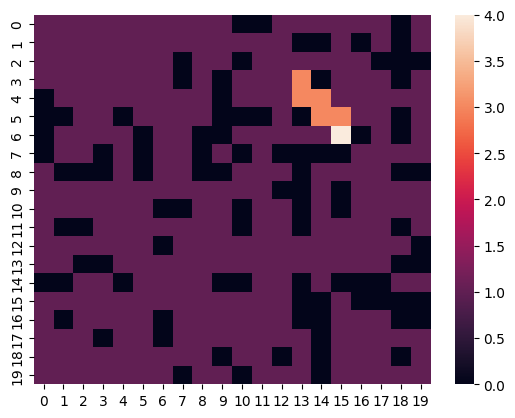

In [63]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

7.063103965061602


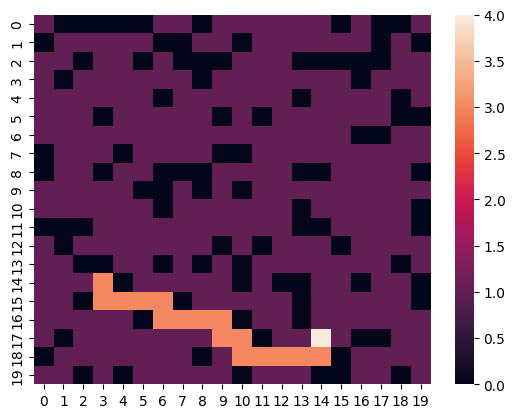

In [78]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

(42, 1) (30, 2)


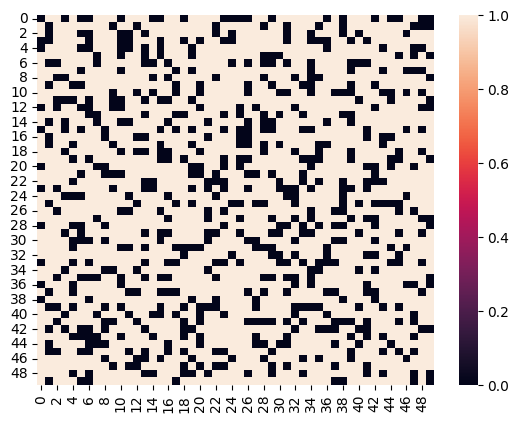

In [79]:
map_shape = (50, 50)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (5, 5),
    'max_episode_steps': 100,
}
heatmap(water_map)

ww = WaterWorld(config=config)
ww.reset()
print(ww.ship.geo, ww.way_point)

3.6383798025958543


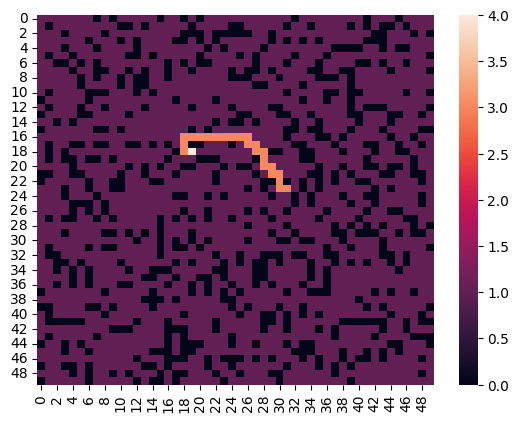

In [101]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

-144.49771739484024


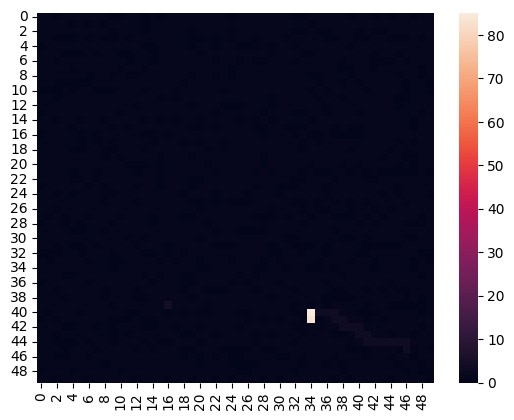

In [102]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])